# Music Classification

Our main goal is to be able to make accurate predictions on a song’s genre. To achieve this, we will explore ways on how neural network architectures and splitting the training and testing data among groups affect our results and see if there are any benefits to do so.

We will also use multiple models - CNN, RNN - to achieve the best accuracy. Our main end goal is to them let anyone play around with our model, input any song and predict its genre.

[genre] is an integer from 0 to 9, indicating the genres: pop, metal, disco, blues, reggae, classical, rock, hiphop, country, jazz respectively.

## Table of content
1. Importing modules
2. Loading Dataset
3. Analyze Distributions
    * Genre Distribution
    * Inspecting genres
4. Split and Preprocess the data
5. Modelling and Training
    * CNN
    * RNN
5. Evaluating Models

## 1. Load modules

First, let's import some libraries that we're going to use in the notebook.

In [1]:
import json
import os
import math
import librosa
import torch
import pandas as pd
import numpy as np
import urllib.request
from PIL import Image
import IPython.display as ipd
from pytube import YouTube
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import librosa.display
import sklearn.metrics
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")

# To ensure reproducible results
RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
tf.random.set_seed(0)

## 2. Load dataset

Let's define some metadata. The dataset can be downloaded [here](https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification?select=Data).

In [2]:
DATASET_PATH = "Data/genres"
JSON_PATH = "data.json"
NUM_SEGMENTS = 10
HOP_LENGTH=512
SAMPLE_RATE = 22050  # music processing
TRACK_DURATION = 30  # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
ALL_GENRES = list()

Once the dataset downloaded, rename **genres_orginal** to **genres** and put the **Data** folder in the <code>DATASET_PATH</code> mentionned above. 

<code>save_mfcc</code> is defined to perform the MFCCs (Mel frequency Cepstral coefficients) extraction and save them into a json file along with their respective genres.

In [3]:
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.
        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """
    # check is data.json exists
    if (os.path.exists(json_path)):
        print(json_path, "already exists. Loading data stopped.")
         # loop through all genre sub-folder
        for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
            if dirpath is not dataset_path:

                # save genre label (i.e., sub-folder name) in the mapping
                semantic_label = dirpath.split("/")[-1]
                ALL_GENRES.append(semantic_label)
        return
    
    json_data = []

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            ALL_GENRES.append(semantic_label)
#             data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

                # load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft,
                                                hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data = dict()
                        data["mfcc"] = mfcc.tolist()
                        data["genre"] = i - 1
                        json_data.append(data)
#                         print("{}, segment:{}".format(file_path, d + 1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(json_data, fp, indent=4)

In [4]:
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

data.json already exists. Loading data stopped.


**Defining a list of unique genres that will be useful later**

In [5]:
GENRE_CATEGORIES = list(dict.fromkeys(ALL_GENRES))
print(GENRE_CATEGORIES)

['pop', 'metal', 'disco', 'blues', 'reggae', 'classical', 'rock', 'hiphop', 'country', 'jazz']


In [6]:
df = pd.read_json('data.json')
df

,mfcc,genre
0,"[[-191.8480224609375, 137.71060180664062, 10.9...",0
1,"[[4.5286760330200195, 57.236793518066406, -0.1...",0
2,"[[-77.95142364501953, 81.06759643554688, 8.640...",0
3,"[[-46.64360427856445, 42.061195373535156, 26.7...",0
4,"[[-117.329833984375, 118.81005859375, 44.30474...",0
...,...,...
9981,"[[-373.26708984375, 132.82028198242188, 7.8544...",9
9982,"[[-148.99798583984375, 142.21856689453125, -49...",9
9983,"[[-115.80660247802734, 152.17578125, -34.64381...",9
9984,"[[-366.3699645996094, 119.11630249023438, 0.67...",9


As we can see above, there are 9986 mfccs in total and the data looks ready for use.

## 3. Analyze data

Let's now have a look at the distributions of the genres. For this, we will use a histogram.

In [7]:
def plot_histogram(x, bi, title, xl, yl, nt, tick):
    '''
    Plot histograms from data, bins and labels
    '''
    fig = plt.figure(figsize=(8,8))
    plt.hist(x, bins=bi)
    plt.title(title)
    plt.xlabel(xl)
    plt.ylabel(yl)
    if tick != 0:
        plt.xticks(np.arange(nt), tick)
    plt.show()

### Genre distribution

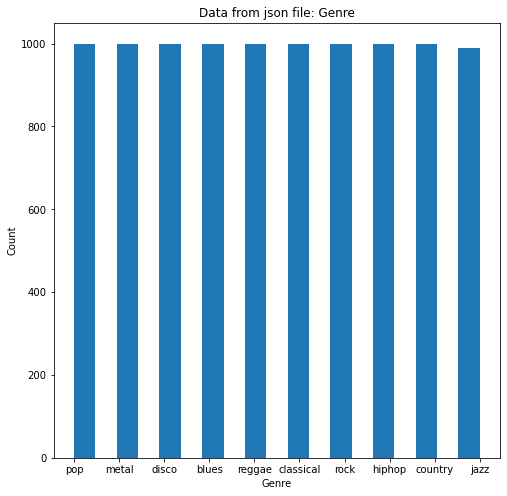

In [8]:
plot_histogram(df.genre, 19, 'Data from json file: Genre', 'Genre', 'Count', 10, GENRE_CATEGORIES)

As we can see from the graph above, our dataset is very balanced. Therefore, we can skip the process of handling imbalanced data.

### Inspecting Genres

We will now look at the visual representation of each genre through a spectrogram which shows how quickly the frequencies themselves are changing over time. The first axis is frequency while the second axis is time.

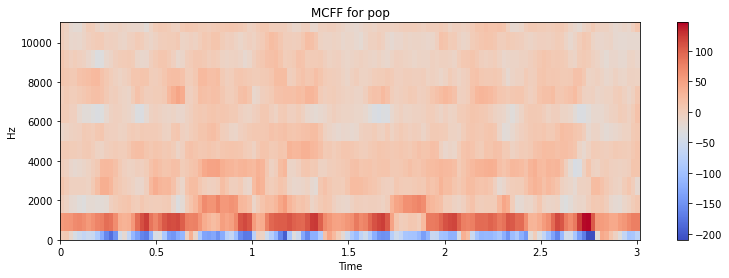

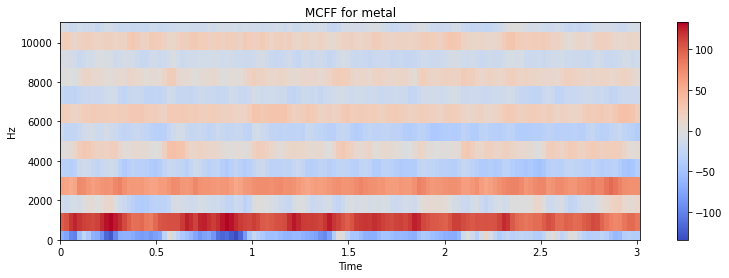

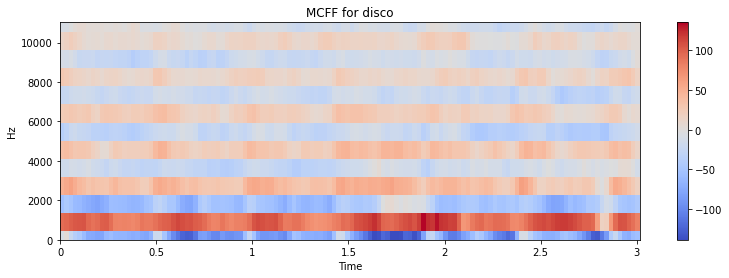

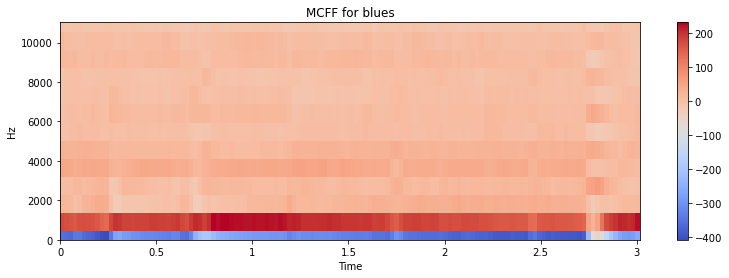

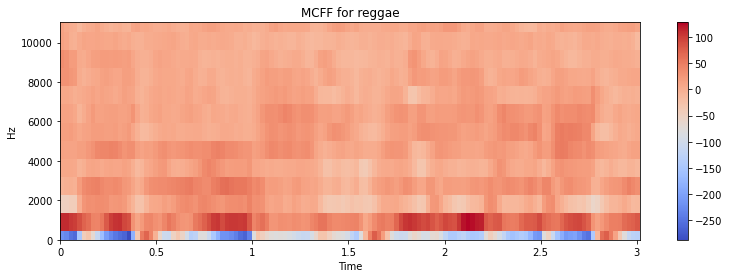

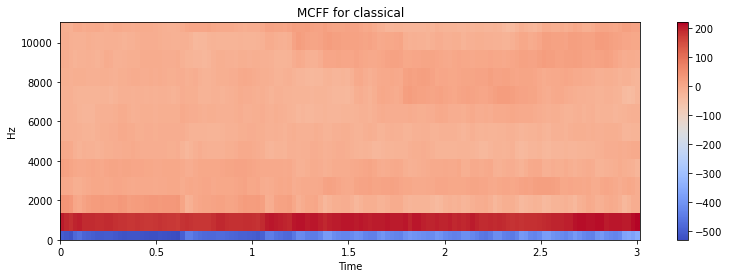

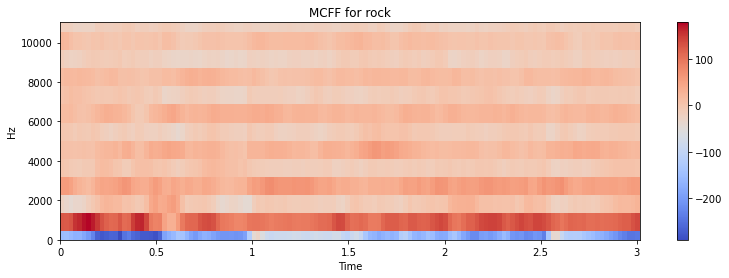

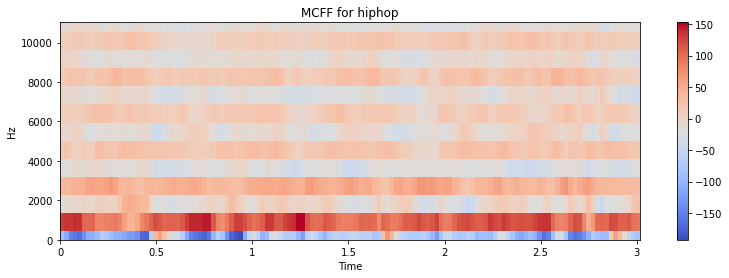

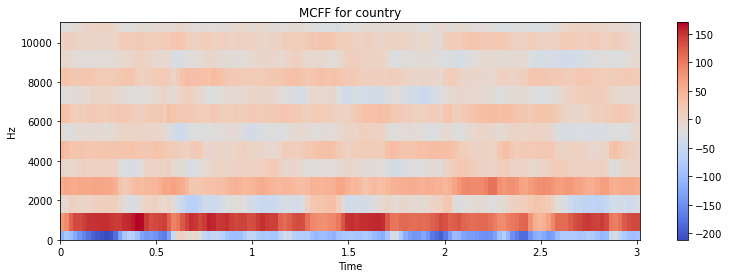

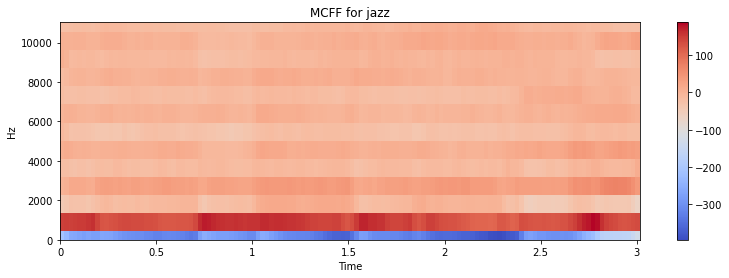

In [9]:
for i, g in enumerate(GENRE_CATEGORIES):
    plt.figure(figsize=(13,4))
    librosa.display.specshow(np.array(np.swapaxes(df[df['genre']==i].mfcc.values[1], 0,1)), x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.title('MCFF for ' + g)

As we can see genres with a low pitch for e.g metal usually has a lower frequency whereas high pitched genres for e.g jazz usually have a higher frequency.

## 4. Split and preprocessing data

First let's create our feature $\boldsymbol{X}$ and target $\boldsymbol{y}$

In [10]:
X = []
with open("data.json", "r") as fp:
    data = json.load(fp)
    for d in data:
        X.append(d['mfcc'])
X = np.array(X, dtype='float32')
X.shape

(9986, 130, 13)

In [11]:
y = np.array(df.loc[:,'genre'].values, dtype='int32')
y.shape

(9986,)

To have the data ready for training, we are going to randomly split $(\boldsymbol{X}, \boldsymbol{y})$ into three parts, with no overlap.

Using a 60/20/20 split, we seperate $\boldsymbol{X}$ and $\boldsymbol{y}$ in training, validation and testing.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

print(len(X_train))
print(len(X_validation))
print(len(X_test))

5991
1997
1998


## 5. Modelling and Training

In this step, we are going to experiment training with different types of models. 

We now define plot_history which will be used later to plot accuracy/loss for training/validation set as a function of the epochs.

In [13]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")
   
    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error evaluation")

    
    fig.tight_layout()

    plt.show()

## Convolutional Neural Networks

First, we will add an axis to our input sets

In [14]:
X_trn = X_train[..., np.newaxis]
X_val = X_validation[..., np.newaxis]
X_tst = X_test[..., np.newaxis]

We are now going to train the data with a Convolutional Neural Network. We start by defining a general function that will help us create the model.

In [15]:
tf.random.set_seed(0)

def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """
    
    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    
    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    # compile with optimizer
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [16]:
input_shape = (X_trn.shape[1], X_trn.shape[2], 1)
cnn = build_model(input_shape)

Here is a summary of the model.

In [17]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 11, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 6, 32)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 6, 32)         128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 2, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 2, 32)         128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 1, 32)         4

The following cell will train the cnn model.

In [18]:
%%time
history = cnn.fit(X_trn, y_train, validation_data=(X_val, y_validation), batch_size=32, epochs=30)

Epoch 1/30
188/188 [==============================] - 4s 21ms/step - loss: 2.5774 - accuracy: 0.1921 - val_loss: 1.8180 - val_accuracy: 0.3741
Epoch 2/30
188/188 [==============================] - 3s 16ms/step - loss: 1.8987 - accuracy: 0.3410 - val_loss: 1.5455 - val_accuracy: 0.4557
Epoch 3/30
188/188 [==============================] - 3s 17ms/step - loss: 1.6515 - accuracy: 0.4138 - val_loss: 1.4029 - val_accuracy: 0.5033
Epoch 4/30
188/188 [==============================] - 3s 17ms/step - loss: 1.5197 - accuracy: 0.4667 - val_loss: 1.3185 - val_accuracy: 0.5303
Epoch 5/30
188/188 [==============================] - 3s 17ms/step - loss: 1.4208 - accuracy: 0.4968 - val_loss: 1.2413 - val_accuracy: 0.5618
Epoch 6/30
188/188 [==============================] - 3s 17ms/step - loss: 1.3004 - accuracy: 0.5326 - val_loss: 1.2059 - val_accuracy: 0.5663
Epoch 7/30
188/188 [==============================] - 3s 16ms/step - loss: 1.2506 - accuracy: 0.5527 - val_loss: 1.1804 - val_accuracy: 0.5799

Having a look at the testing accuracy. We obtain the following accuracy:

In [19]:
test_loss, test_acc = cnn.evaluate(X_tst, y_test, verbose=2)
print('\nTest accuracy:', "{:.2f}%".format(test_acc*100))

63/63 - 0s - loss: 0.8279 - accuracy: 0.7237

Test accuracy: 72.37%


Let's now take a look at the learning curves.

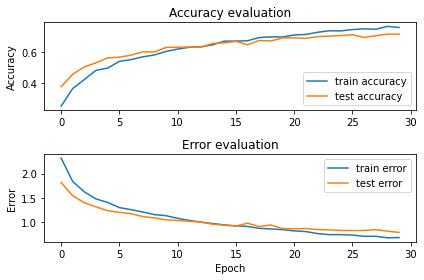

In [20]:
plot_history(history)

From the test error of the error evaluation plot, we can observe we were quite overfitting the model as from epoch 15.

## Recurrent neural network 

We are now going to train the data with a Recurrent Neural Network. As usual, we start by defining a general function that will help us create the model.

In [22]:
tf.random.set_seed(0)

def build_model(input_shape):
    """Generates RNN-LSTM model
    :param input_shape (tuple): Shape of input set
    :return model: RNN-LSTM model
    """

    # build network topology
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(keras.layers.LSTM(64))

    # dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


    return model

In [23]:
input_shape = (X_train.shape[1], X_train.shape[2])  # 130, 13
rnn = build_model(input_shape)

Here is a summary of the rnn model.

In [24]:
rnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 130, 64)           19968     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 57,802
Trainable params: 57,802
Non-trainable params: 0
_________________________________________________________________


The following cell will train the rnn model.

In [25]:
%%time
history = rnn.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

Epoch 1/30
188/188 [==============================] - 19s 93ms/step - loss: 2.2641 - accuracy: 0.1557 - val_loss: 2.1010 - val_accuracy: 0.2989
Epoch 2/30
188/188 [==============================] - 17s 93ms/step - loss: 2.0545 - accuracy: 0.2945 - val_loss: 1.8703 - val_accuracy: 0.3590
Epoch 3/30
188/188 [==============================] - 17s 92ms/step - loss: 1.8473 - accuracy: 0.3590 - val_loss: 1.7025 - val_accuracy: 0.4081
Epoch 4/30
188/188 [==============================] - 17s 92ms/step - loss: 1.7119 - accuracy: 0.4063 - val_loss: 1.5856 - val_accuracy: 0.4472
Epoch 5/30
188/188 [==============================] - 17s 91ms/step - loss: 1.5772 - accuracy: 0.4483 - val_loss: 1.5135 - val_accuracy: 0.4632
Epoch 6/30
188/188 [==============================] - 17s 91ms/step - loss: 1.5212 - accuracy: 0.4780 - val_loss: 1.4633 - val_accuracy: 0.4842
Epoch 7/30
188/188 [==============================] - 17s 91ms/step - loss: 1.4881 - accuracy: 0.4897 - val_loss: 1.4207 - val_accuracy:

Having a look at the testing accuracy. We obtain the following accuracy:

In [26]:
test_loss, test_acc = rnn.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', "{:.2f}%".format(test_acc*100))

63/63 - 2s - loss: 1.1650 - accuracy: 0.5911

Test accuracy: 59.11%


Let's take a look at the learning curves

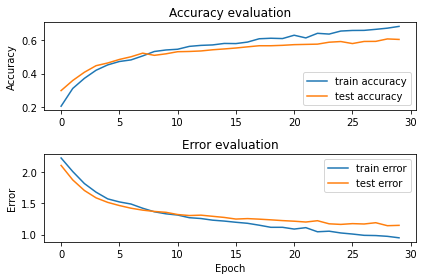

In [27]:
plot_history(history)

From the test error of the error evaluation plot, we can observe we were quite overfitting the model as from epoch 15.

## 6. Evaluating Models

In this section, we'll try to draw out conclusions from the models trained and compare their results.

We define a function plot_confusion_matrix to plot tensorflow predictions.

In [29]:
def plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Plot confusion matrix from y_true and y_pred with labels.
    '''
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                                  display_labels=labels)
    disp.plot()
    plt.xticks(rotation='vertical')
    plt.show()

### Comparing best neural network models

In [30]:
y_cnn_pred = np.argmax(cnn.predict(X_tst), axis=1)

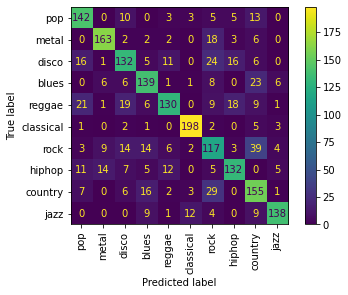

In [31]:
plot_confusion_matrix(y_test, y_cnn_pred, GENRE_CATEGORIES)

In [32]:
print(sklearn.metrics.classification_report(y_test,y_cnn_pred))

              precision    recall  f1-score   support

           0       0.71      0.78      0.74       181
           1       0.84      0.83      0.84       196
           2       0.67      0.63      0.65       211
           3       0.71      0.73      0.72       190
           4       0.77      0.61      0.68       214
           5       0.90      0.93      0.92       212
           6       0.53      0.55      0.54       211
           7       0.75      0.69      0.72       191
           8       0.58      0.71      0.64       219
           9       0.87      0.80      0.83       173

    accuracy                           0.72      1998
   macro avg       0.73      0.73      0.73      1998
weighted avg       0.73      0.72      0.72      1998



As we can see from the confusion matrix above, our cnn model misclassified rock as country the most, while it best prediction is classical music.

In [33]:
y_rnn_pred = np.argmax(rnn.predict(X_test), axis=1)

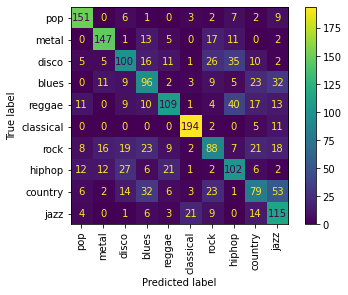

In [34]:
plot_confusion_matrix(y_test, y_rnn_pred, GENRE_CATEGORIES)

In [35]:
print(sklearn.metrics.classification_report(y_test,y_rnn_pred))

              precision    recall  f1-score   support

           0       0.77      0.83      0.80       181
           1       0.76      0.75      0.76       196
           2       0.54      0.47      0.50       211
           3       0.47      0.51      0.49       190
           4       0.66      0.51      0.57       214
           5       0.85      0.92      0.88       212
           6       0.48      0.42      0.45       211
           7       0.49      0.53      0.51       191
           8       0.45      0.36      0.40       219
           9       0.45      0.66      0.53       173

    accuracy                           0.59      1998
   macro avg       0.59      0.60      0.59      1998
weighted avg       0.59      0.59      0.59      1998



As we can see from the confusion matrix above, our rnn model misclassified country as jazz the most, while it best prediction is classical music.

## Just for fun 😁

We will now try to predict any song from youtube using our best model, which in our case is CNN.

During training, we trained our models based on ten 3 seconds segments (30 seconds audio length) as we are more likely to find distinct patterns for each genre. 

When predicting the youtube audios, we are going to take the maximum number of 3 sec segments as the length will be longer than 30 seconds.

For example, if a song's length is 151 seconds, we will have 50 segments discarding the 1 second. From the 50 predictions, the final prediction will be the mode.

In [36]:
def load_yt_link(link):
    video = YouTube(link)
    audio = video.streams.filter(only_audio=True, file_extension='mp4').first()
    file = audio.download()

    # convert mp4 to wav
    base, ext = os.path.splitext(file)
    wav_file = base + '.wav'
    os.rename(file, wav_file)
    
    return video, wav_file

def load_yt_feature(video, file):
    dd = []
    SAMPLES_PER_TRACK = SAMPLE_RATE * ((video.length // 3) * 3)
    segments = video.length // 3
    samples_per_segment = int(SAMPLES_PER_TRACK / segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / 512)
    signal, sample_rate = librosa.load(file, sr=SAMPLE_RATE)
    for d in range(segments):
        # calculate start and finish sample for current segment
        start = samples_per_segment * d
        finish = start + samples_per_segment
#         print(signal[start:finish].shape)
        mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=13, n_fft=2048,
                                hop_length=512)
        mfcc = mfcc.T
        if len(mfcc) == num_mfcc_vectors_per_segment:
            dd.append(mfcc.tolist())
    return np.array(dd), segments

def most_frequent(List):
    return max(set(List), key = List.count)

def predict_cnn(x, segments):
    preds = []
#     print(segments)
    for i in range(segments):
        x_ = x[i][np.newaxis, ...]
        swapped = np.moveaxis(x_, 0, 2)
        x_cnn = np.expand_dims(swapped, 0)
#         print(x_cnn.shape)
        prediction = cnn.predict(x_cnn)
        # get index with max value
        predicted_index = np.argmax(prediction, axis=1)
#         print(predicted_index)
        preds.append(predicted_index[0])
#         print(predicted_index)

        pred_index = most_frequent(preds)
    return GENRE_CATEGORIES[pred_index]

def predict_rnn(x):
    preds = []
    prediction = rnn.predict(x)
    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)
#     print(predicted_index)
    preds.append(predicted_index[0])

    pred_index = most_frequent(preds)
    return GENRE_CATEGORIES[pred_index]

Input music video link from youtube

In [37]:
print("Enter youtube video link: ")
link = input()

Enter youtube video link: 
https://www.youtube.com/watch?v=Bg59q4puhmg


In [41]:
video, file = load_yt_link(link)
x, segments = load_yt_feature(video, file)

The following is our prediction:

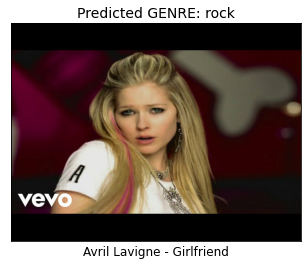

In [42]:
urllib.request.urlretrieve(video.thumbnail_url, 'thumbnail.png')  
img = Image.open("thumbnail.png")
plt.xlabel(video.title, fontsize='12')
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Predicted GENRE: ' + str(predict_cnn(x, segments)), fontsize='14')
ipd.Audio(file)